<a href="https://colab.research.google.com/github/pasticeta-hub/Investigaci-n-de-operaciones/blob/main/proyecto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CPM para el lanzamiento de un negocio de repostería

 método de la ruta crítica  para planear la apertura de una panadería/repostería, desde la planeación inicial hasta la campaña de lanzamiento.  
Con CPM buscamos:
- Estimar la **duración mínima del proyecto**.
- Identificar **tareas críticas** (holgura = 0) que no se pueden retrasar.
- Detectar **holguras** para reasignar recursos sin mover la fecha de apertura.
- Visualizar dependencias con una **red AON** (Activity-On-Node) y un **Gantt**.

**Herramientas.** Python (NetworkX + Matplotlib).


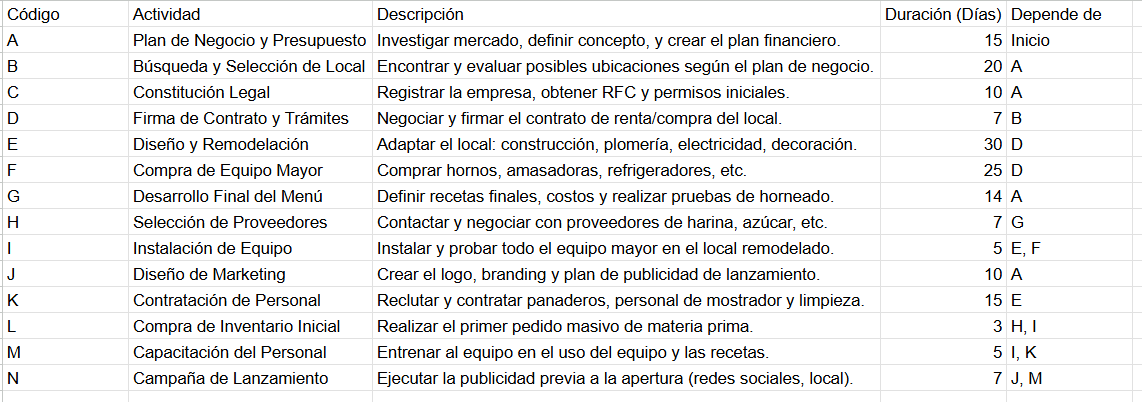



## Datos del proyecto: duraciones y dependencias

- `actividades_duracion`: duración en **días** por actividad (A…N).  
- `dependencias`: pares `(u, v)` que significan “**u debe terminar antes de que v comience**”.  
- Añadimos nodos **Inicio** y **FIN** para marcar el comienzo/termino del proyecto.


In [64]:
# Duraciones
actividades_duracion = {
    'A': 15, 'B': 20, 'C': 10, 'D': 7, 'E': 30, 'F': 25, 'G': 14,
    'H': 7, 'I': 5, 'J': 10, 'K': 15, 'L': 3, 'M': 5, 'N': 7
}

# Dependencias (predecesor, sucesor)
dependencias = [
    ('Inicio', 'A'), ('A', 'B'), ('A', 'C'), ('A', 'G'), ('A', 'J'),
    ('B', 'D'), ('D', 'E'), ('D', 'F'), ('E', 'I'), ('F', 'I'),
    ('G', 'H'), ('H', 'L'), ('I', 'L'), ('E', 'K'), ('I', 'M'),
    ('K', 'M'), ('J', 'N'), ('M', 'N'), ('L', 'FIN'), ('N', 'FIN')
]


## Grafo dirigido + pesos correctos en flechas

NetworkX calcula la ruta más larga **en función de pesos de *aristas***.  
Como nuestras duraciones están **en los nodos**, convertimos esa duración a las **flechas** usando la convención AON:  
> el **peso de (u ->v)** es la **duración de v**.

Esto asegura que `dag_longest_path` use los días correctos.


In [83]:
G = nx.DiGraph()
G.add_nodes_from(['Inicio', 'FIN'])

# Añadimos nodos A..N con atributo de duración (útil para etiquetas)
for codigo, dur in actividades_duracion.items():
    G.add_node(codigo, duration=dur)

# Añadir aristas (dependencias)
G.add_edges_from(dependencias)

# Asignar peso "duration" a CADA arista como la duración del nodo destino (convención AON)
for u, v in G.edges():
    G[u][v]['duration'] = actividades_duracion.get(v, 0)  # 0 para Inicio/FIN


## Cálculo de la ruta crítica

Usamos `nx.dag_longest_path` y `nx.dag_longest_path_length` con `weight='duration'`.  
Así obtenemos:
- **Ruta crítica** (secuencia de nodos).
- **Duración total** del proyecto (suma de duraciones a lo largo de la ruta).


In [104]:
# Seguridad: el grafo debe ser acíclico
assert nx.is_directed_acyclic_graph(G), "El grafo tiene ciclos; revisa dependencias."

ruta_critica_nodos = nx.dag_longest_path(G, weight='duration')
project_duration = nx.dag_longest_path_length(G, weight='duration')

print(f"Duración Total del Proyecto: {project_duration} días")
print("Ruta Crítica:", " -> ".join(ruta_critica_nodos))

# Conjunto de aristas que forman la ruta crítica (para resaltarlas)
cp_edges = set(zip(ruta_critica_nodos, ruta_critica_nodos[1:]))


Duración Total del Proyecto: 99 días
Ruta Crítica: Inicio -> A -> B -> D -> E -> K -> M -> N


## Estilos de dibujo y etiquetas

- **Nodos**: rosa si están en la ruta crítica, gris en otro caso.  
- **Aristas**: gruesas si pertenecen a la ruta crítica.  
- **Etiqueta de arista**: “`Xdías`” con la duración del **nodo destino**.


In [112]:
# Posición de nodos: Graphviz 'dot' si está disponible; si no, spring_layout
try:
    from networkx.drawing.nx_pydot import graphviz_layout
    pos = graphviz_layout(G, prog='dot')
except Exception:
    pos = nx.spring_layout(G, seed=7)

# Colores de nodos
colores_nodos = ['pink' if n in ruta_critica_nodos else 'gray' for n in G.nodes()]

# Grosor de aristas: solo las que están exactamente en la ruta crítica
grosor_aristas = [3.0 if (u, v) in cp_edges else 1.2 for u, v in G.edges()]

# Etiquetas de nodos (solo texto del nodo)
etiquetas_nodos = {n: str(n) for n in G.nodes()}

# Etiquetas de aristas (días = duración del sucesor)
etiquetas_aristas = {(u, v): f"{G[u][v]['duration']} días" for u, v in G.edges()}


## Dibujo de la red con ruta crítica resaltada

- Ruta crítica **en grueso**.  (segun porque no se ve del todoxd)
- Flechas con **duración** del nodo destino.  
- Título con nombre del proyecto.


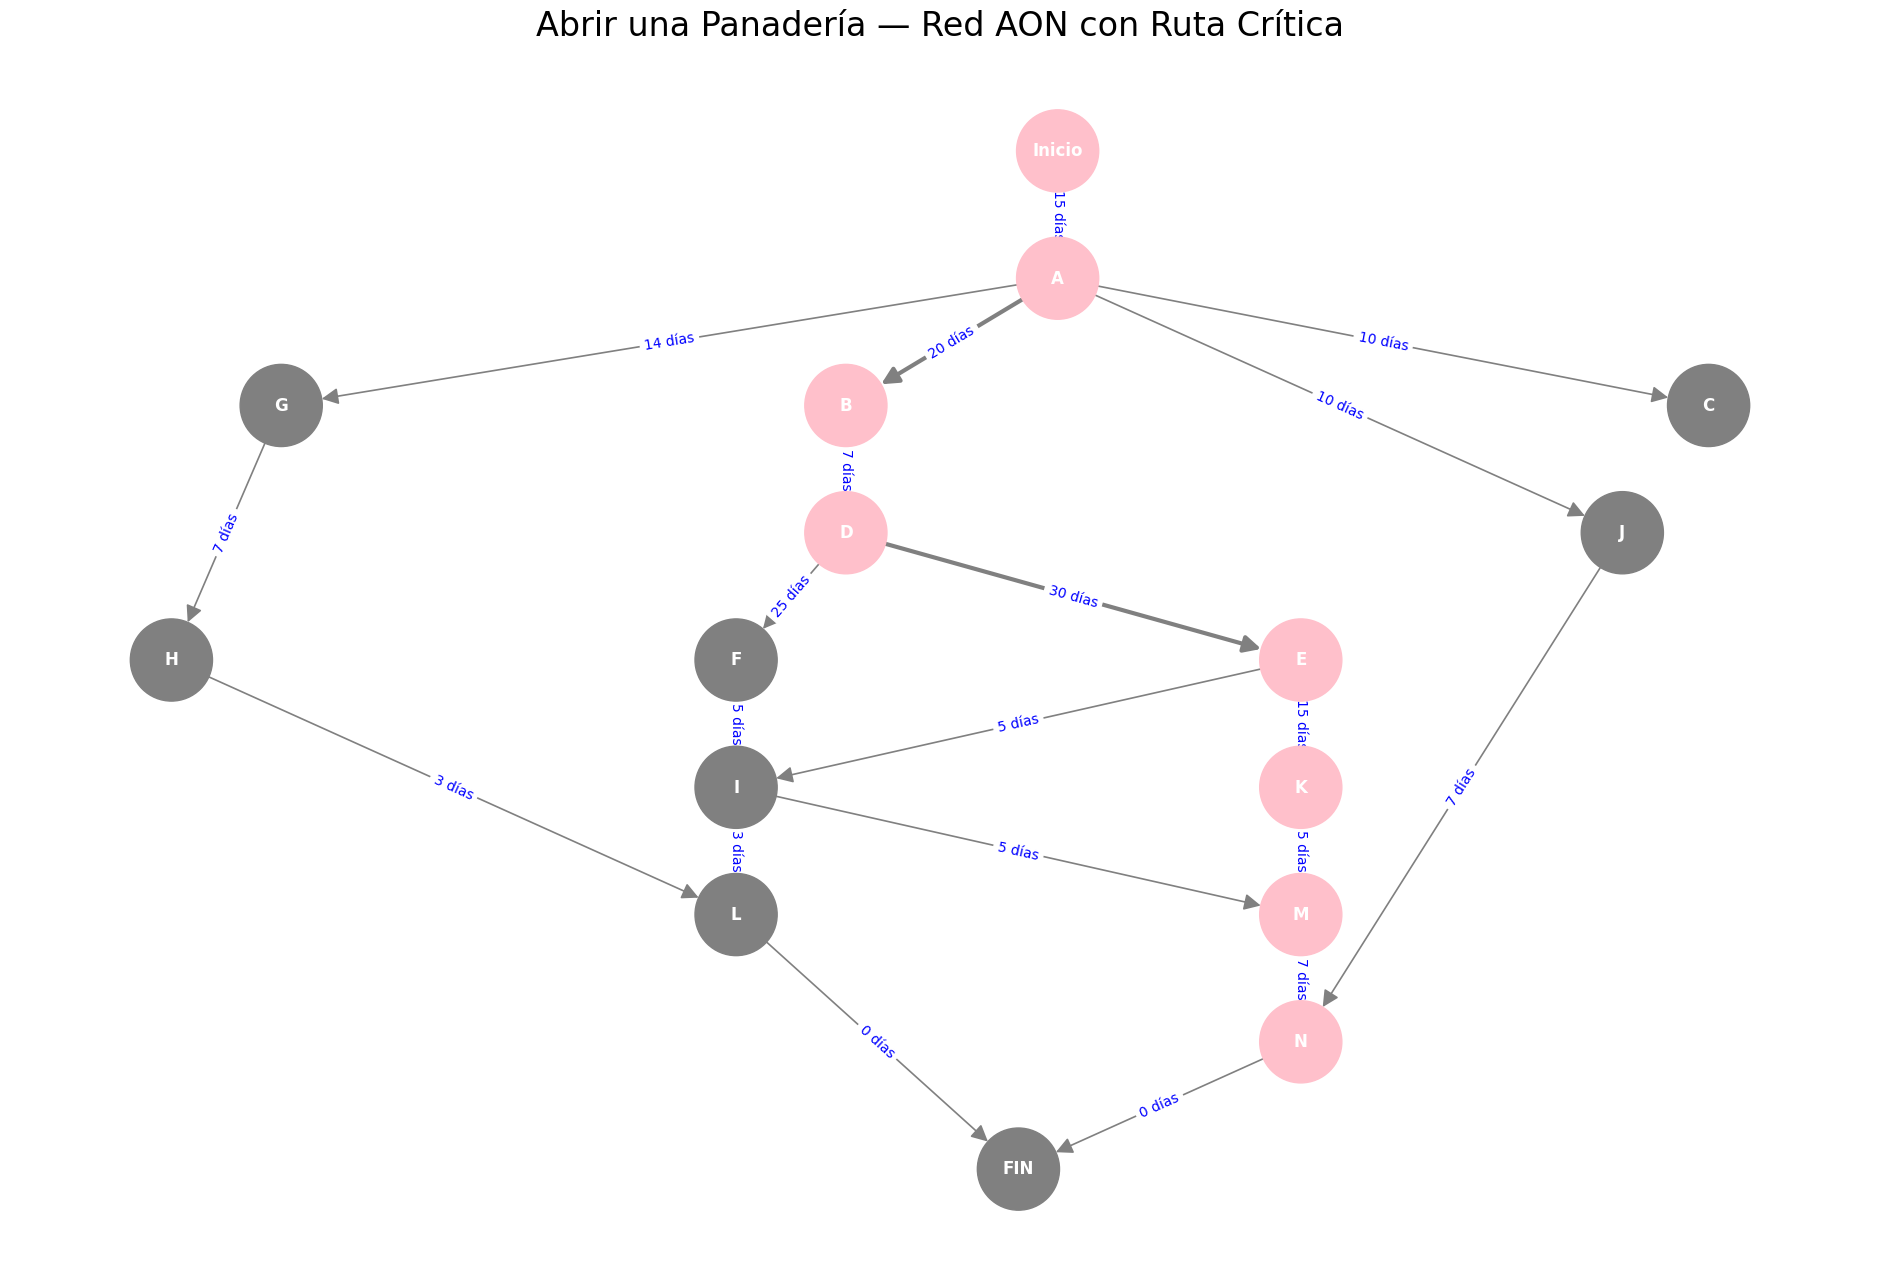

In [113]:
plt.figure(figsize=(24, 16))

nx.draw_networkx(
    G, pos=pos, with_labels=False,
    node_color=colores_nodos, node_size=3500,
    width=grosor_aristas, edge_color='grey', arrowsize=25
)

nx.draw_networkx_labels(G, pos, labels=etiquetas_nodos,
                        font_color='white', font_weight='bold', font_size=12)

nx.draw_networkx_edge_labels(G, pos, edge_labels=etiquetas_aristas,
                             font_color='blue', font_size=10, label_pos=0.5)

plt.title('Abrir una Panadería — Red AON con Ruta Crítica', size=24)
plt.box(False)
plt.show()
